<a href="https://colab.research.google.com/github/tleitch/Machine-Learning-for-Algorithmic-Trading-Second-Edition/blob/master/02_market_and_fundamental_data/03_data_providers/01_pandas_datareader_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remote data access using pandas

The pandas library enables access to data displayed on websites using the `read_html()` function and access to the API endpoints of various data providers through the related `pandas-datareader` library.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install mplfinance
%matplotlib inline
import os
from datetime import datetime
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

## Download html table with SP500 constituents

The download of the content of one or more html tables works as follows, for instance for the constituents of the S&P500 index from Wikipedia

In [5]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(sp_url, header=0)[0]

In [6]:
sp500_constituents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 505 non-null    object
 1   Security               505 non-null    object
 2   SEC filings            505 non-null    object
 3   GICS Sector            505 non-null    object
 4   GICS Sub-Industry      505 non-null    object
 5   Headquarters Location  505 non-null    object
 6   Date first added       453 non-null    object
 7   CIK                    505 non-null    int64 
 8   Founded                505 non-null    object
dtypes: int64(1), object(8)
memory usage: 35.6+ KB


In [7]:
sp500_constituents.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


## pandas-datareader for Market Data

`pandas` used to facilitate access to data providers' APIs directly, but this functionality has moved to the related pandas-datareader library. The stability of the APIs varies with provider policies, and as of June 2o18 at version 0.7, the following sources are available

See [documentation](https://pandas-datareader.readthedocs.io/en/latest/); functionality frequently changes as underlying provider APIs evolve.

### Yahoo Finance

In [8]:
start = '2014'
end = datetime(2017, 5, 24)

yahoo= web.DataReader('FB', 'yahoo', start=start, end=end)
yahoo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 855 entries, 2014-01-02 to 2017-05-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       855 non-null    float64
 1   Low        855 non-null    float64
 2   Open       855 non-null    float64
 3   Close      855 non-null    float64
 4   Volume     855 non-null    int64  
 5   Adj Close  855 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 46.8 KB


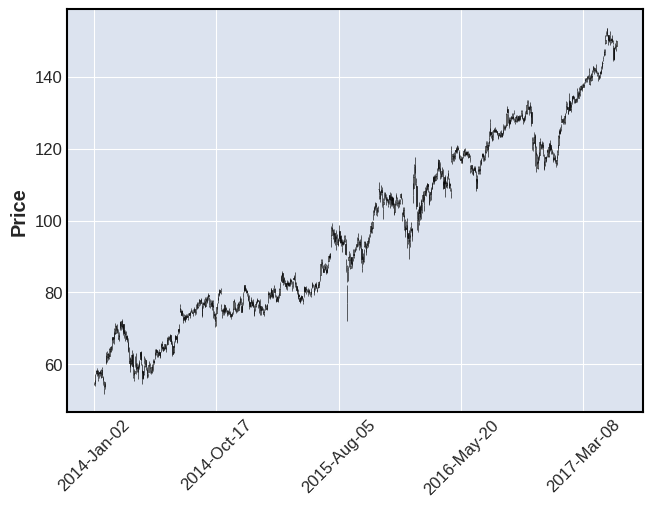

<Figure size 640x480 with 0 Axes>

In [9]:
mpf.plot(yahoo.drop('Adj Close', axis=1), type='candle')
plt.tight_layout()

### IEX

IEX is an alternative exchange started in response to the HFT controversy and portrayed in Michael Lewis' controversial Flash Boys. It aims to slow down the speed of trading to create a more level playing field and has been growing rapidly since launch in 2016 while still small with a market share of around 2.5% in June 2018.

> **Note:** IEX now requires an [API](https://iexcloud.io/) key after registration for (free) account that you can store as environment variable and retrieve as illustrated below, or pass directly via keyword argument to `pandas_datareader`.

In [10]:
#IEX_API_KEY=os.getenv('IEX_API_KEY')

In [13]:
start = datetime(2015, 2, 9)
# end = datetime(2017, 5, 24)

iex = web.DataReader('FB', 'iex', start, api_key="")
iex.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1588 entries, 2015-02-09 to 2021-05-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1588 non-null   float64
 1   high    1588 non-null   float64
 2   low     1588 non-null   float64
 3   close   1588 non-null   float64
 4   volume  1588 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 74.4+ KB


In [14]:
iex.tail()

,open,high,low,close,volume
date,,,,,
2021-05-24,318.21,325.9500,318.03,324.63,16445356
2021-05-25,327.08,329.1800,324.80,327.79,16436965
2021-05-26,328.35,329.8299,325.82,327.66,9686917
2021-05-27,328.00,333.7800,326.76,332.75,20477726
2021-05-28,331.00,332.8684,328.33,328.73,12037430


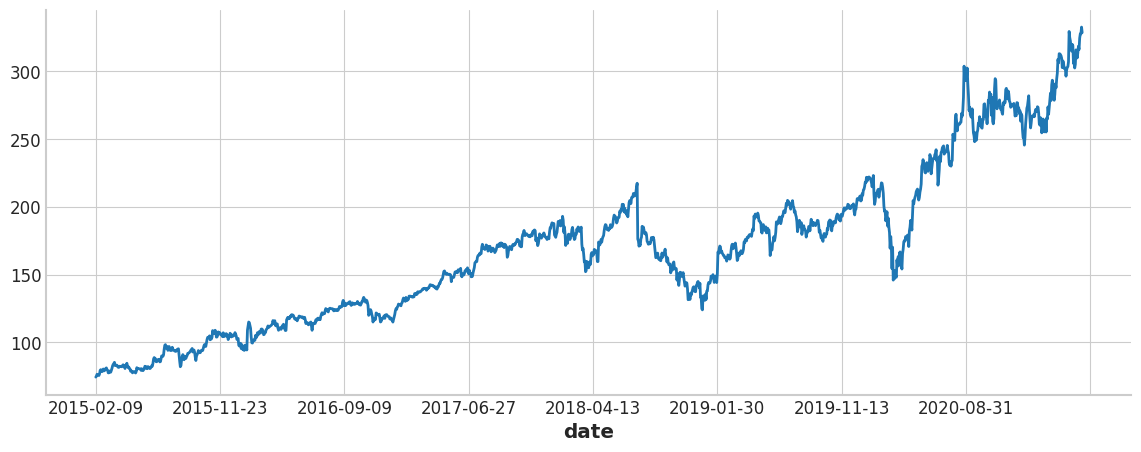

In [15]:
sns.set_style('whitegrid')
iex.close.plot(figsize=(14, 5))
sns.despine()

#### Book Data

In addition to historical EOD price and volume data, IEX provides real-time depth of book quotations that offer an aggregated size of orders by price and side. This service also includes last trade price and size information.

DEEP is used to receive real-time depth of book quotations direct from IEX. The depth of book quotations received via DEEP provide an aggregated size of resting displayed orders at a price and side, and do not indicate the size or number of individual orders at any price level. Non-displayed orders and non-displayed portions of reserve orders are not represented in DEEP.

DEEP also provides last trade price and size information. Trades resulting from either displayed or non-displayed orders matching on IEX will be reported. Routed executions will not be reported.

Only works on trading days.

In [16]:
book = web.get_iex_book('AAPL')

In [17]:
list(book.keys())

['symbol',
 'marketPercent',
 'volume',
 'lastSalePrice',
 'lastSaleSize',
 'lastSaleTime',
 'lastUpdated',
 'bids',
 'asks',
 'systemEvent',
 'tradeBreaks']

In [18]:
orders = pd.concat([pd.DataFrame(book[side]).assign(side=side) for side in ['bids', 'asks']])
orders.head()

,side


In [19]:
for key in book.keys():
    try:
        print(f'\n{key}')
        print(pd.DataFrame(book[key]))
    except:
        print(book[key])


symbol
AAPL

marketPercent
0

volume
0

lastSalePrice
0

lastSaleSize
0

lastSaleTime
0

lastUpdated
0

bids
Empty DataFrame
Columns: []
Index: []

asks
Empty DataFrame
Columns: []
Index: []

systemEvent
Empty DataFrame
Columns: []
Index: []

tradeBreaks
Empty DataFrame
Columns: []
Index: []


In [20]:
pd.DataFrame(book['trades']).head()

KeyError: ignored

### Quandl

Obtain Quandl [API Key](https://www.quandl.com/tools/api) and store in environment variable as `QUANDL_API_KEY`.

In [ ]:
symbol = 'FB.US'

quandl = web.DataReader(symbol, 'quandl', '2015-01-01')
quandl.info()

### FRED

In [21]:
start = datetime(2010, 1, 1)

end = datetime(2013, 1, 27)

gdp = web.DataReader('GDP', 'fred', start, end)

gdp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2010-01-01 to 2013-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     13 non-null     float64
dtypes: float64(1)
memory usage: 208.0 bytes


In [22]:
inflation = web.DataReader(['CPIAUCSL', 'CPILFESL'], 'fred', start, end)
inflation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 2010-01-01 to 2013-01-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CPIAUCSL  37 non-null     float64
 1   CPILFESL  37 non-null     float64
dtypes: float64(2)
memory usage: 888.0 bytes


### Fama/French

In [23]:
from pandas_datareader.famafrench import get_available_datasets
get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [24]:
ds = web.DataReader('5_Industry_Portfolios', 'famafrench')
print(ds['DESCR'])

5 Industry Portfolios
---------------------

This file was created by CMPT_IND_RETS using the 202104 CRSP database. It contains value- and equal-weighted returns for 5 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2021 Kenneth R. French

  0 : Average Value Weighted Returns -- Monthly (59 rows x 5 cols)
  1 : Average Equal Weighted Returns -- Monthly (59 rows x 5 cols)
  2 : Average Value Weighted Returns -- Annual (5 rows x 5 cols)
  3 : Average Equal Weighted Returns -- Annual (5 rows x 5 cols)
  4 : Number of Firms in Portfolios (59 rows x 5 cols)
  5 : Average Firm Size (59 rows x 5 cols)
  6 : Sum of BE / Sum of ME (5 rows x 5 cols)
  7 : Value-Weighted Average of BE/ME (5 rows x 5 cols)


### World Bank

In [25]:
from pandas_datareader import wb
gdp_variables = wb.search('gdp.*capita.*const')
gdp_variables.head()

,id,name,unit,source,sourceNote,sourceOrganization,topics
716,6.0.GDPpc_constant,"GDP per capita, PPP (constant 2011 internation...",,LAC Equity Lab,GDP per capita based on purchasing power parit...,b'World Development Indicators (World Bank)',Economy & Growth
9194,NY.GDP.PCAP.KD,GDP per capita (constant 2010 US$),,World Development Indicators,GDP per capita is gross domestic product divid...,"b'World Bank national accounts data, and OECD ...",Economy & Growth
9196,NY.GDP.PCAP.KN,GDP per capita (constant LCU),,World Development Indicators,GDP per capita is gross domestic product divid...,"b'World Bank national accounts data, and OECD ...",Economy & Growth
9198,NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2017 internation...",,World Development Indicators,GDP per capita based on purchasing power parit...,"b'International Comparison Program, World Bank...",Economy & Growth
9199,NY.GDP.PCAP.PP.KD.87,"GDP per capita, PPP (constant 1987 internation...",,WDI Database Archives,,b'',


In [26]:
wb_data = wb.download(indicator='NY.GDP.PCAP.KD', 
                      country=['US', 'CA', 'MX'], 
                      start=1990, 
                      end=2019)
wb_data.head()

NY.GDP.PCAP.KD
country year                
Canada  2019    51583.104884
        2018    51465.905583
        2017    51167.711860
        2016    50193.750410
        2015    50262.027666

### OECD

In [27]:
df = web.DataReader('TUD', 'oecd', start='2010', end='2019')
df[['Japan', 'United States']]

Country                  Japan                ... United States                     
Source     Administrative data                ...   Survey data                     
Series               Employees Union members  ... Union members Trade union  density
Year                                          ...                                   
2010-01-01             37100.0       12509.0  ...       17403.0                 21.6
2011-01-01             37460.0       12437.0  ...       19335.0                 23.2
2012-01-01             38990.0       12309.0  ...       20986.0                 23.4
2013-01-01             40120.0       12369.0  ...       20095.0                 22.3
2014-01-01             41020.0       12526.0  ...           NaN                  NaN
2015-01-01             42090.0       12520.0  ...       17717.0                 19.5
2016-01-01             43010.0       12418.0  ...       16996.0                 17.4
2017-01-01             43830.0       12343.0  ...       16975.0                 17.0
2018-01-01             45650.0       12227.0  ...       17002.0                 16.2

[9 rows x 12 columns]



### Stooq

Google finance stopped providing common index data download. The Stooq site had this data for download for a while but is currently broken, awaiting release of [fix](https://github.com/pydata/pandas-datareader/issues/594)

In [28]:
index_url = 'https://stooq.com/t/'
ix = pd.read_html(index_url)
len(ix)

47

In [29]:
sp500_stooq = web.DataReader('^SPX', 'stooq')
sp500_stooq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1257 entries, 2021-05-28 to 2016-06-02
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1257 non-null   float64
 1   High    1257 non-null   float64
 2   Low     1257 non-null   float64
 3   Close   1257 non-null   float64
 4   Volume  1257 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.9 KB


In [30]:
sp500_stooq.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-05-28,4210.77,4218.36,4203.57,4204.11,1958464949
2021-05-27,4201.94,4213.38,4197.78,4200.88,3407781249
2021-05-26,4191.59,4202.61,4184.11,4195.99,2087338274
2021-05-25,4205.94,4213.42,4182.52,4188.13,2117333013
2021-05-24,4170.16,4209.52,4170.16,4197.05,1848676717


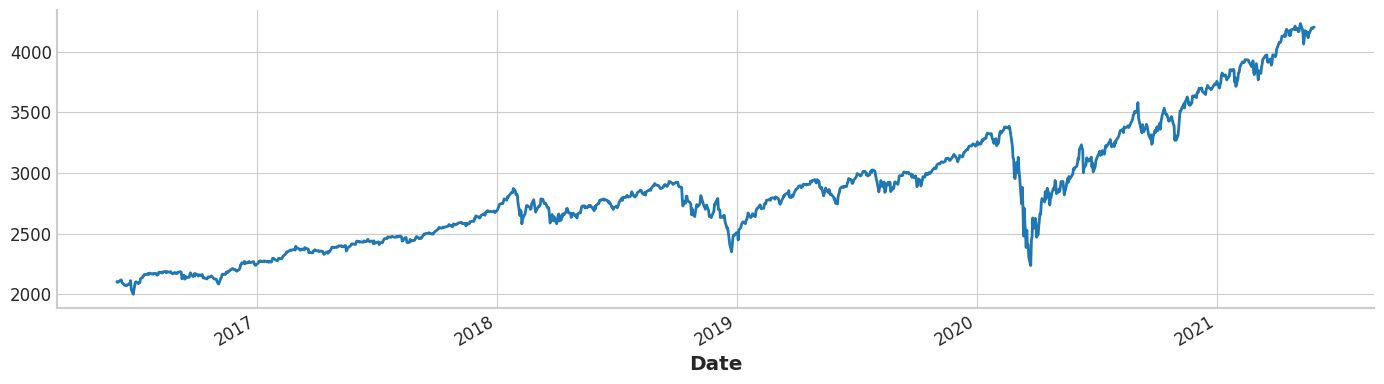

In [31]:
sp500_stooq.Close.plot(figsize=(14,4))
sns.despine()
plt.tight_layout()

### NASDAQ Symbols

In [32]:
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
symbols = get_nasdaq_symbols()
symbols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10754 entries, A to ZYXI
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Nasdaq Traded     10754 non-null  bool    
 1   Security Name     10754 non-null  object  
 2   Listing Exchange  10754 non-null  category
 3   Market Category   10754 non-null  object  
 4   ETF               10754 non-null  bool    
 5   Round Lot Size    10754 non-null  float64 
 6   Test Issue        10754 non-null  bool    
 7   Financial Status  4719 non-null   category
 8   CQS Symbol        6035 non-null   object  
 9   NASDAQ Symbol     10754 non-null  object  
 10  NextShares        10754 non-null  bool    
dtypes: bool(4), category(2), float64(1), object(4)
memory usage: 567.5+ KB


### Tiingo

Requires [signing up](https://api.tiingo.com/) and storing API key in environment

In [33]:
df = web.get_data_tiingo('GOOG', api_key=os.getenv('TIINGO_API_KEY'))

ValueError: ignored

In [ ]:
df.info()